<a href="https://colab.research.google.com/github/SRIKARREDDY-dotorg/Hand-Written-hindi-script-recognition/blob/master/FYP_COVID19_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install kaggle

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [21]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [22]:
pwd

'/content/gdrive/My Drive/kaggle'

In [23]:
!kaggle datasets download -d asraf047/covid19-pneumonia-normal-chest-xray-pa-dataset

covid19-pneumonia-normal-chest-xray-pa-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
!unzip \*.zip  && rm *.zip

Archive:  covid19-pneumonia-normal-chest-xray-pa-dataset.zip
replace covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:

import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from datetime import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
df = pd.read_csv('/content/gdrive/My Drive/kaggle/metadata.csv')
df_y = df['class']
df_x = df['directory']

In [38]:
df_x

0         covid/COVID19(308).jpg
1       covid/COVID-19 (839).jpg
2       covid/COVID-19 (105).jpg
3       covid/COVID-19 (379).jpg
4         covid/COVID19(443).jpg
                  ...           
4570     normal/00000398_004.png
4571     normal/00000975_000.png
4572     normal/00000766_009.png
4573     normal/00000105_003.png
4574     normal/00000697_001.png
Name: directory, Length: 4575, dtype: object

In [39]:
df_y

0       1
1       1
2       1
3       1
4       1
       ..
4570    0
4571    0
4572    0
4573    0
4574    0
Name: class, Length: 4575, dtype: int64

In [40]:
df_y.value_counts()

2    1525
1    1525
0    1525
Name: class, dtype: int64

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, stratify=df_y, test_size=0.20, random_state=7)

In [42]:
Y_train.value_counts()

1    1220
2    1220
0    1220
Name: class, dtype: int64

In [43]:
Y_test.value_counts()

2    305
1    305
0    305
Name: class, dtype: int64

In [44]:
test = pd.concat([X_test, Y_test], axis = 1)
test.head()

,directory,class
614,covid/COVID-19 (506).jpg,1
2473,pneumonia/person23_bacteria_82.jpeg,2
501,covid/COVID19(241).jpg,1
912,covid/COVID-19 (219).jpg,1
1270,covid/COVID-19 (549).jpg,1


In [45]:
def filter_images():
    input_path="/content/gdrive/My Drive/kaggle"
    output_path="/content/gdrive/My Drive/kaggle/Chest_Xray_PA_Dataset"
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    classs=['normal','covid','pneumonia']
    for c in classs:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        print(path_from)
        image=cv2.imread(path_from)
        #print(image)
        #print(1)
        try:
          result=cv2.GaussianBlur(image,(5,5),0)
        except:
          print('hi')
          continue
        #print(image)
        path_to = "{}/{}".format(output_path, row['directory'])
        #print(path_to)
        cv2.imwrite(path_to,result)
filter_images()

/content/gdrive/My Drive/kaggle/covid/COVID19(308).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (839).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (105).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (379).jpg
/content/gdrive/My Drive/kaggle/covid/COVID19(443).jpg
/content/gdrive/My Drive/kaggle/covid/COVID19(282).jpg
/content/gdrive/My Drive/kaggle/covid/COVID19(433).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (725).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (378).jpg
/content/gdrive/My Drive/kaggle/covid/COVID19(533).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (25).jpeg
/content/gdrive/My Drive/kaggle/covid/COVID19(128).jpg
/content/gdrive/My Drive/kaggle/covid/COVID19(534).jpg
/content/gdrive/My Drive/kaggle/covid/COVID19(343).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (403).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (686).jpg
/content/gdrive/My Drive/kaggle/covid/COVID-19 (59).jpg
/content/gdrive/My Drive/kaggle/covid/A7E260CE-8

In [46]:
def copy_images(df, directory):
    
    # input and output directory 
    input_path = "/content/gdrive/My Drive/kaggle/Chest_Xray_PA_Dataset"     
    output_path = "/content/gdrive/My Drive/kaggle/dataset/" + directory

    # remove all files from previous fold
    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    # create folder for files from this fold
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # create subfolders for each class
    classs=['normal','covid','pneumonia']
    for c in classs:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)
        
    # copy files
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        path_to = "{}/{}".format(output_path, row['directory'])
        shutil.copy(path_from, path_to)

In [47]:
copy_images(test, 'test')

In [48]:
len(os.listdir('/content/gdrive/My Drive/kaggle/dataset/test/covid'))

305

In [49]:
len(os.listdir('/content/gdrive/My Drive/kaggle/dataset/test/normal'))

305

In [50]:
len(os.listdir('/content/gdrive/My Drive/kaggle/dataset/test/pneumonia'))

305

In [51]:
def get_model():
    
    # Input layer
    img_dims=224
    inputs = Input(shape=(img_dims, img_dims, 3))

    # 1st conv block
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(inputs)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 2nd conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 3rd conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 4th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 5th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
#     x = AveragePooling2D(pool_size=(4, 4))(x)

#     # LSTM layer
#     x = Reshape((49, 512))(x)
#     x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    
    # FC layer
    x = Flatten(name="flatten")(x)
    x = Dense(units=64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    opt = RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

In [52]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [53]:
test_generator = test_datagen.flow_from_directory(
    directory=r"./dataset/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 915 images belonging to 3 classes.


In [54]:
from math import floor
N_FOLDS = 5
EPOCHS = 50
INIT_LR = 3e-4
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1

skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [ModelCheckpoint(filepath='best_cnn_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step))), tensorboard_callback]

In [55]:
class_to_label_map = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'}

1    976
2    976
0    976
Name: class, dtype: int64
2    244
1    244
0    244
Name: class, dtype: int64
Running fold 1
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     

KeyboardInterrupt: ignored

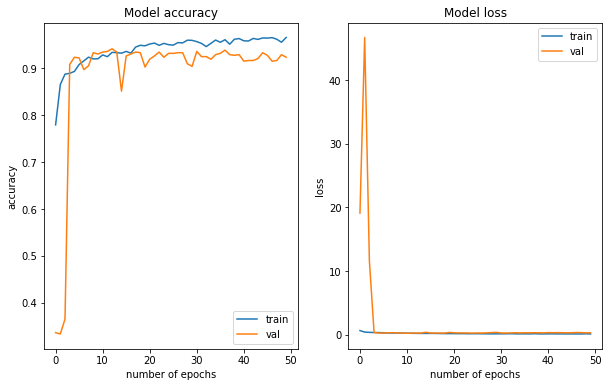

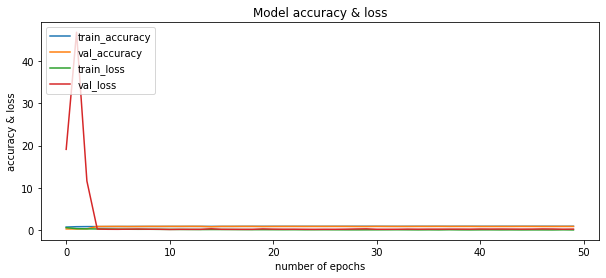

In [56]:
submission_prediction = []
submission_predictions = []

for epoch, (train_index, val_index) in enumerate(skf.split(X_train, Y_train)):
    x_train, x_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train, y_val = Y_train.iloc[train_index], Y_train.iloc[val_index]
    
    print(y_train.value_counts())
    print(y_val.value_counts())

    train = pd.concat([x_train, y_train], axis=1)
    val = pd.concat([x_val, y_val], axis = 1)
    
    # copy the images according to the fold
    copy_images(train, 'train')
    copy_images(val, 'val')
    
    print('Running fold '+ str(epoch+1))
    
    # CREATE MODEL
    model = get_model()
    model.summary()
    
    # Load Model Weights
    if epoch != 0:
        model.load_weights('best_cnn_model.h5') 
    
    train_generator = train_datagen.flow_from_directory(
        directory=r"./dataset/train/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    valid_generator = val_datagen.flow_from_directory(
        directory=r"./dataset/val/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    
    history = model.fit_generator(
                generator=train_generator,
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                validation_data=valid_generator,
                validation_steps=valid_generator.n//valid_generator.batch_size,
                epochs=EPOCHS,
                callbacks=callbacks
    )
    
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = 'history.csv'
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax = ax.ravel()
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('number of epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.savefig('accuracy_performance_graph'+'_'+str(epoch)+'.png')
    
    test_generator.reset()
    predY=model.predict_generator(
            test_generator,
            steps=test_generator.n//test_generator.batch_size,
            verbose=1)
    submission_prediction.append(predY)

    if epoch >= 1:
        submission_predictions.append(predY)
        
    testY = test_generator.classes
    confusion__matrix=confusion_matrix(testY, np.argmax(predY, axis = -1))
    cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True))
    print (cr)
    print(confusion__matrix)
    
    cm_df = pd.DataFrame(confusion__matrix)
    cr_df = pd.DataFrame(cr)
    with open(hist_csv_file, mode='a') as f:
        hist_df.to_csv(f)
        cm_df.to_csv(f)
        cr_df.to_csv(f)
    
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Model accuracy & loss")
    plt.ylabel("accuracy & loss")
    plt.xlabel("number of epochs")
    plt.legend(["train_accuracy", "val_accuracy", "train_loss", "val_loss"], loc="upper left")
    plt.savefig('accuracy_loss_performance'+'_'+str(epoch)+'.png')
    
    model.save('final_cnn_model.h5') 
    
    del history
    del model
    gc.collect()